# Pygmalion - Projet autocomplétion

**Sprint 3 : Résaux de neurones - Seq2Seq**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataScientest-Studio/Pygmalion/blob/main/notebooks/3-Seq2Seq.ipynb)

Certaines parties ne fonctionnent pas dans Google Colab.

# 1. Modélisation sans mécanisme d'attention

## I. Data loading and preprocessing

Montage du disque et import des packages

In [ ]:
# Import des packages
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import time
from string import ascii_lowercase
from tqdm.notebook import tqdm
import random

import unicodedata
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

import pickle
import gzip

import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, concatenate, Input
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split

import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Necessaire pour sauvegarder les données sur google drive (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Indiquez le dossier de sauvegarde de vos fichiers
path = '/content/drive/MyDrive/Pygmalion/'

In [ ]:
# Activez le GPU dans google colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Chargement du Dataset ENRON

In [ ]:
# Chargement du dataframe à partir de google drive
# Le dataset est préparé dans le fichier 1-Exploration_des_données_et_DataViz
df_emails = pd.read_csv(path+'df_emails.csv')

### General Functions

In [ ]:
def save_object(obj, filename, zip=False):
    if zip:
        with gzip.open(filename,'wb') as outp:
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    else:
        with open(filename, 'wb') as outp:
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
            
def load_object(filename, zip=False):
    if zip:
        with gzip.open(filename,'rb') as inp:
            return pickle.load(inp)
    else:
        with open(filename, 'rb') as inp:
            return pickle.load(inp)
        
def random_split_df(df, frac = 0.1, random_state=None):
    df_test = df.sample(frac = frac, random_state=random_state)
    df_train = df.drop(df_test.index)
    return df_train, df_test

## II. Word embeding

### Tokenization

Nettoyage du texte et suppression des mots vides (très longs)

In [ ]:
# Chargement du fichier df.gz
df = load_object(path+"df.gz", zip=True)

In [ ]:
# Pre-processing du texte : très long (30 min)
# A n'executer que si nécessaire - priviligiez le chargement ci-dessus
df = pd.DataFrame(df_emails['content'])
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w, stop=True):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    # remove one or two-character words
    #w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    if stop:
        mots = word_tokenize(w.strip())
        mots = [mot for mot in mots if mot not in stop_words]
        return ' '.join(mots).strip()
    else:
        return w

start_time = time.time()
df['clean'] = df['content'].apply(lambda x :preprocess_sentence(x, stop=False))
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
df['stop'] = df['content'].apply(lambda x :preprocess_sentence(x, stop=True))
print("--- %s seconds ---" % (time.time() - start_time))
df.head()

In [ ]:
# Sauvegarde du fichier df.gz
start_time = time.time()
save_object(df, path+"df.gz", zip=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 141.3524136543274 seconds ---


In [ ]:
# Séparation du dataset en deux
df_train, df_test = random_split_df(df, frac = 0.1, random_state=42)

In [ ]:
# Tokenization du text clean
start_time = time.time()
tokenizer_clean = tf.keras.preprocessing.text.Tokenizer()
tokenizer_clean.fit_on_texts(df_train['clean'])
tokenizer_clean.num_words = 10000

word2idx_clean = tokenizer_clean.word_index
idx2word_clean = tokenizer_clean.index_word
vocab_size_clean = tokenizer_clean.num_words
print("--- %s seconds ---" % (time.time() - start_time))


# Tokenization du text clean sans stop words
start_time = time.time()
tokenizer_stop = tf.keras.preprocessing.text.Tokenizer()
tokenizer_stop.fit_on_texts(df_train['stop'])
tokenizer_stop.num_words = 10000

word2idx_stop = tokenizer_stop.word_index
idx2word_stop = tokenizer_stop.index_word
vocab_size_stop = tokenizer_stop.num_words
print("--- %s seconds ---" % (time.time() - start_time))

--- 62.08402228355408 seconds ---
--- 44.05795693397522 seconds ---


### Word embedding from scratch

In [ ]:
def sentenceToData(tokens, WINDOW_SIZE):
    window = np.concatenate((np.arange(-WINDOW_SIZE,0),np.arange(1,WINDOW_SIZE+1)))
    X,Y=([],[])
    for word_index, word in enumerate(tokens) :
        if ((word_index - WINDOW_SIZE >= 0) and (word_index + WINDOW_SIZE <= len(tokens) - 1)) :
            Y.append(word)
            X.append([tokens[word_index-i] for i in window])
    return X, Y

def df_to_data(df, tokenizer, WINDOW_SIZE):
    X, Y = ([], [])
    with tqdm(total = len(df)) as pbar:
        for content in df:
            for sentence in content.split("."):
                word_list = tokenizer.texts_to_sequences([sentence])[0]
                if len(word_list) >= WINDOW_SIZE:
                    X1, Y1 = sentenceToData(word_list, WINDOW_SIZE//2)
                    X.extend(X1)
                    Y.extend(Y1)
            pbar.update(1)
    
    X = np.array(X).astype(int)
    y = np.array(Y).astype(int).reshape([-1,1])
    return X, y

In [ ]:
def model_from_scratch(df_train, df_test, tokenizer, WINDOW_SIZE, embedding_dim, batch_size, epochs, callbacks=None):
    print("Preparing data for the CBOW model")
    X_train, y_train = df_to_data(df_train, tokenizer, WINDOW_SIZE)
    print('Shape of X_train :', X_train.shape)
    print('Shape of y_train :', y_train.shape)
    X_test, y_test = df_to_data(df_test, tokenizer, WINDOW_SIZE)
    print('Shape of X_test :', X_test.shape)
    print('Shape of y_test :', y_test.shape)
    vocab_size = tokenizer.num_words
    print("Preparing the CBOW model")
    print("vocab_size:", vocab_size)
    print("embedding_dim:", embedding_dim)
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(vocab_size, activation='softmax'))
    
    print("CBOW model fiting")
    # Fitting model_scratch
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs=epochs,
                        validation_data = (X_test, y_test),
                        callbacks=callbacks)
    return history, model

In [ ]:
early_stopping = EarlyStopping(
                                patience=10, # Attendre 10 epochs avant application
                                min_delta = 0.01, # si au bout de 10 epochs la fonction de perte ne varie pas de 1%, 
                                            # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur epsilon
                                    episilon= 0.01,
                                    factor=0.5,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

In [ ]:
nb_mail = [10000, 50000]
data_type = ["clean","stop"]
history_l = []
model_l = []
for n in nb_mail:
    for d in data_type:
        print("CBOW model for", str(n), "emails and ", d, " filtering")
        data_train = df_train[d].head(n)
        data_test = df_test[d].head(int(n/10))
        if d == "clean":
            tok = tokenizer_clean
        else:
            tok = tokenizer_stop
        history, model = model_from_scratch(data_train, data_test, tok, 5, 300, 128, 20, callbacks=[early_stopping, reduce_learning_rate])
        history_l.append(history)
        model_l.append(model)
        print("\n")

CBOW model for 10000 emails and  clean  filtering
Preparing data for the CBOW model


  0%|          | 0/10000 [00:00<?, ?it/s]

Shape of X_train : (1154048, 4)
Shape of y_train : (1154048, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape of X_test : (130067, 4)
Shape of y_test : (130067, 1)
Preparing the CBOW model
vocab_size: 10000
embedding_dim: 300
CBOW model fiting
Epoch 1/20
9016/9016 [==============================] - 110s 12ms/step - loss: 5.6608 - accuracy: 0.1753 - val_loss: 5.8095 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 2/20
9016/9016 [==============================] - 107s 12ms/step - loss: 4.4711 - accuracy: 0.2745 - val_loss: 5.6986 - val_accuracy: 0.1791 - lr: 0.0010
Epoch 3/20
9016/9016 [==============================] - 106s 12ms/step - loss: 3.8775 - accuracy: 0.3274 - val_loss: 5.7436 - val_accuracy: 0.1796 - lr: 0.0010
Epoch 4/20
9016/9016 [==============================] - 107s 12ms/step - loss: 3.4588 - accuracy: 0.3715 - val_loss: 5.8406 - val_accuracy: 0.1802 - lr: 0.0010
Epoch 5/20
9016/9016 [==============================] - ETA: 0s - loss: 3.1513 - accuracy: 0.4069
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9016/9016 [==============================] - 1

  0%|          | 0/10000 [00:43<?, ?it/s]

Shape of X_train : (538180, 4)
Shape of y_train : (538180, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape of X_test : (61220, 4)
Shape of y_test : (61220, 1)
Preparing the CBOW model
vocab_size: 10000
embedding_dim: 300
CBOW model fiting
Epoch 1/20
4205/4205 [==============================] - 56s 13ms/step - loss: 6.7784 - accuracy: 0.1144 - val_loss: 7.2434 - val_accuracy: 0.0852 - lr: 0.0010
Epoch 2/20
4205/4205 [==============================] - 55s 13ms/step - loss: 5.1103 - accuracy: 0.2399 - val_loss: 7.0778 - val_accuracy: 0.1026 - lr: 0.0010
Epoch 3/20
4205/4205 [==============================] - 52s 12ms/step - loss: 4.0295 - accuracy: 0.3505 - val_loss: 7.1574 - val_accuracy: 0.1105 - lr: 0.0010
Epoch 4/20
4205/4205 [==============================] - 55s 13ms/step - loss: 3.2436 - accuracy: 0.4541 - val_loss: 7.3445 - val_accuracy: 0.1162 - lr: 0.0010
Epoch 5/20
4202/4205 [============================>.] - ETA: 0s - loss: 2.6742 - accuracy: 0.5394
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4205/4205 [==============================] - 51s 12m

  0%|          | 0/50000 [00:00<?, ?it/s]

Shape of X_train : (6658629, 4)
Shape of y_train : (6658629, 1)


  0%|          | 0/5000 [00:00<?, ?it/s]

Shape of X_test : (748712, 4)
Shape of y_test : (748712, 1)
Preparing the CBOW model
vocab_size: 10000
embedding_dim: 300
CBOW model fiting
Epoch 1/20
52021/52021 [==============================] - 651s 13ms/step - loss: 4.8165 - accuracy: 0.2406 - val_loss: 5.2311 - val_accuracy: 0.2035 - lr: 0.0010
Epoch 2/20
52021/52021 [==============================] - 648s 12ms/step - loss: 3.9620 - accuracy: 0.3076 - val_loss: 5.2292 - val_accuracy: 0.2098 - lr: 0.0010
Epoch 3/20
52021/52021 [==============================] - 648s 12ms/step - loss: 3.6920 - accuracy: 0.3308 - val_loss: 5.3114 - val_accuracy: 0.2115 - lr: 0.0010
Epoch 4/20
52021/52021 [==============================] - 648s 12ms/step - loss: 3.5614 - accuracy: 0.3420 - val_loss: 5.3927 - val_accuracy: 0.2119 - lr: 0.0010
Epoch 5/20
52020/52021 [============================>.] - ETA: 0s - loss: 3.4877 - accuracy: 0.3479
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52021/52021 [=======================

  0%|          | 0/50000 [00:07<?, ?it/s]

Shape of X_train : (3118562, 4)
Shape of y_train : (3118562, 1)


  0%|          | 0/5000 [00:00<?, ?it/s]

Shape of X_test : (347803, 4)
Shape of y_test : (347803, 1)
Preparing the CBOW model
vocab_size: 10000
embedding_dim: 300
CBOW model fiting
Epoch 1/20
24364/24364 [==============================] - 305s 12ms/step - loss: 5.6476 - accuracy: 0.2043 - val_loss: 6.4805 - val_accuracy: 0.1415 - lr: 0.0010
Epoch 2/20
24364/24364 [==============================] - 298s 12ms/step - loss: 4.1475 - accuracy: 0.3455 - val_loss: 6.5369 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 3/20
24364/24364 [==============================] - 306s 13ms/step - loss: 3.5614 - accuracy: 0.4157 - val_loss: 6.7582 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 4/20
24362/24364 [============================>.] - ETA: 0s - loss: 3.2549 - accuracy: 0.4545
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24364/24364 [==============================] - 296s 12ms/step - loss: 3.2549 - accuracy: 0.4545 - val_loss: 6.9811 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 5/20
24364/24364 [=======================

In [ ]:
# Save the history on hard drive
history_data = []
for history in history_l:
    history_data.append(history.history)

save_object(history_data, path+"history_CBOW_scratch.gz", zip=True)

In [ ]:
# Load the history from hard drive
history_data = load_object(path+"history_CBOW_scratch.gz", zip=True)

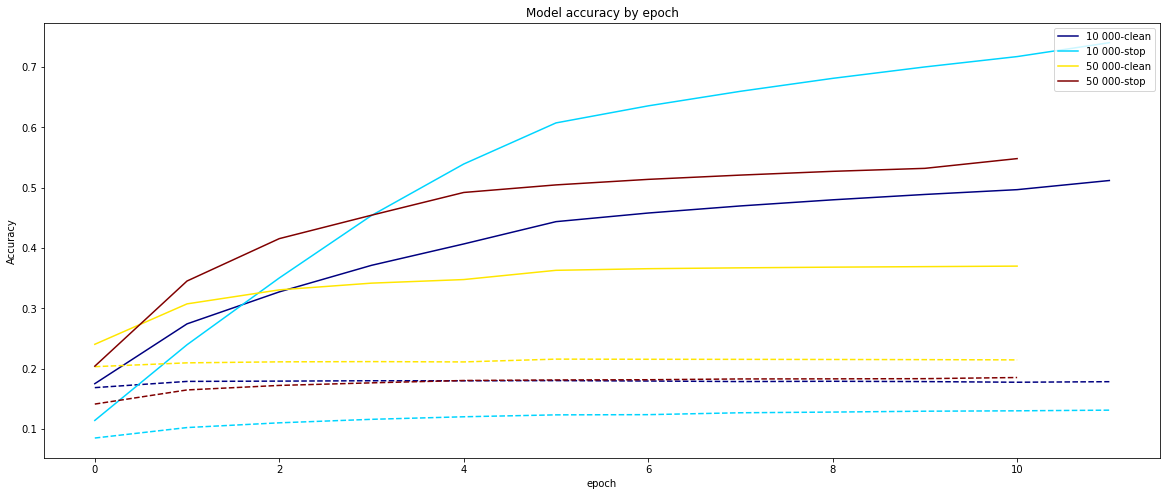

In [ ]:
n = len(history_data)
colors = plt.cm.jet(np.linspace(0,1,n))

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)


for i, history in enumerate(history_data):
    label = ["10 000-clean", "10 000-stop", "50 000-clean", "50 000-stop"]
    ax.plot(history['accuracy'], "-", c = colors[i], label = label[i])
    ax.plot(history['val_accuracy'], "--", c = colors[i])

plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
ax.legend(loc=1)

plt.show()

On voit que le nombre d'email et important pour limiter le sur-apprentissage. Globalement, le modèle avec 50 000 emails semble apporté la meilleur efficacité de validation (21%).

### Word Embedding with Gensim

In [ ]:
def df_to_data_gensim(df, vocab, WINDOW_SIZE):
    X, y = ([], [])
    with tqdm(total = len(df)) as pbar:
        for content in df:
            for sentence in content.split("."):
                word_list = sentence.split()
                word_list = list(filter(None,[vocab.get(word, None) for word in word_list]))
                if len(word_list) >= WINDOW_SIZE:
                    X1, Y1 = sentenceToData(word_list, WINDOW_SIZE//2)
                    X.extend(X1)
                    y.extend(Y1)
            pbar.update(1)
    
    X = np.array(X).astype(int)
    y = np.array(y).astype(int).reshape([-1,1])
    return X, y

In [ ]:
def gensim_to_keras_embedding(weights, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [ ]:
# Consomme beaucoup de RAM, peut être difficile à faire tourner sur Google Colab.
data = df_train["clean"].str.split()
vector_size=300
max_final_vocab=10000
w2v = Word2Vec(data, size=vector_size, max_final_vocab=max_final_vocab)

In [ ]:
vocab = w2v.wv.key_to_index
WINDOW_SIZE = 5
X_train, y_train = df_to_data_gensim(df_train["clean"].head(100000), vocab, WINDOW_SIZE)
print('Shape of X_train :', X_train.shape)
print('Shape of y_train :', y_train.shape)
X_test, y_test = df_to_data_gensim(df_test["clean"].head(10000), vocab, WINDOW_SIZE)
print('Shape of X_train :', X_test.shape)
print('Shape of y_train :', y_test.shape)

AttributeError: ignored

In [ ]:
w2v_layer = gensim_to_keras_embedding(w2v.wv.vectors, train_embeddings=False)
model_w2v = Sequential()
model_w2v.add(w2v_layer)
model_w2v.add(GlobalAveragePooling1D())
vocab_size = len(vocab)
model_w2v.add(Dense(vocab_size, activation='softmax'))

# Fitting model_gensim
opt = keras.optimizers.Adam(learning_rate=0.001)
model_w2v.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 3
history_w2v = model_w2v.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs=epochs,
                        validation_data = (X_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

In [ ]:
# Load the glove-wiki-gigaword-300 model and save it to hard-drive
model_gensim_loaded = api.load("glove-wiki-gigaword-300")
file = "\Save\model_gensim_loaded.gz"

save_object(model_gensim_loaded, path+file, zip=True)

In [ ]:
# Load the glove-wiki-gigaword-300 model from hard-drive
file = "\Save\model_gensim_loaded.gz"
model_gensim_loaded = load_object(path+file, zip=True)

In [ ]:
loaded_layer = gensim_to_keras_embedding(model_gensim_loaded.vectors, train_embeddings=False)

model_loaded = Sequential()
model_loaded.add(loaded_layer)
model_loaded.add(GlobalAveragePooling1D())
vocab_size = len(vocab)
model_loaded.add(Dense(vocab_size, activation='softmax'))

# Fitting model_gensim
opt = keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 3
history_loaded = model_loaded.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs=epochs,
                        validation_data = (X_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

In [ ]:
# Save the history to hard drive
history_w2v = history_w2v.history
history_loaded = history_loaded.history
file = r"\Save\history_GENSIM.gz"

save_object((history_w2v, history_loaded), path+file, zip=True)

In [ ]:
# Load the history to hard drive
file = "\Save\history_GENSIM.gz"
(history_w2v, history_loaded) = load_object(path+file, zip=True)

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ax.plot(history_w2v['accuracy'], "-", c = "r", label = "Gensim fitted")
ax.plot(history_w2v['val_accuracy'], "--", c = "r")

ax.plot(history_loaded['accuracy'], "-", c = "g", label = "Gensim loaded")
ax.plot(history_loaded['val_accuracy'], "--", c = "g")

plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
ax.legend(loc=1)

plt.show()

## III. Context

### Tokens preparation and context vs predictions

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def sentences_from_df(df):
    sentences = []
    # lecture ligne par ligne
    print("Cleaning of dataframe")
    with tqdm(total = len(df)) as pbar:
        for l in df:
            # nettoyage de la phase
            l = unicode_to_ascii(l.lower())
            l = re.sub(r"([?!,¿])", r" \1 ", l)
            l = re.sub(r'[" "]+', " ", l)
            # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
            l = re.sub(r"[^a-zA-Z?.!,']+", " ", l)
            # remove one or two-character words
            #w = re.sub(r'\b\w{0,2}\b', '', w)
            for s in l.split('.'):
                sentences.append(s.split())
            pbar.update(1)
        sentences = list(filter(None, sentences))
    return sentences

In [ ]:
# Preparation of the tokenizer on the full Dataset. Can be loaded later.
sentences = sentences_from_df(df_emails["content"])
start_time = time.time()
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences )
print("--- %s seconds ---" % (time.time() - start_time))
del sentences

Cleaning of dataframe


  0%|          | 0/517401 [00:00<?, ?it/s]

--- 72.175612449646 seconds ---


In [ ]:
# Save the tokenizer on the hard drive
save_object(tokenizer, path+"tokenizer.gz", zip=True)

In [ ]:
# Load the tokenizer from hard drive
file = "tokenizer.gz"
tokenizer = load_object(path+"tokenizer.gz", zip=True)

In [ ]:
def process_sentences(sentence, n_previous = 5):
    list_result = []
    for i in range(0,len(sentence)):
        context=[]
        for j in range(-n_previous, 0):
            if (i+j)<0:
                context.append("0")
            else:
                context.append(sentence[i+j])
        target = sentence[i]
        l = random.randint(0, len(target))
        start_word = target[:l]
        end_word = target[l:]
        list_result.append([context, target, start_word, end_word])
    return list_result

def process_from_df(df, n_previous = 5):
    result_list = []
    sentences = sentences_from_df(df)
    print("Production of context dataframe")
    with tqdm(total = len(sentences)) as pbar:
        for sentence in sentences:
            list_sentence = process_sentences(sentence, n_previous)
            if list_sentence:
                result_list.extend(list_sentence)
            pbar.update(1)
    return pd.DataFrame(result_list).rename({0:'context', 1:'prediction', 2:'start_word', 3:'end_word'},axis=1)

In [ ]:
def tokenize(sentences, tokenizer, maxlen=None):
    # transformation des phrases en séquences
    seq = tokenizer.texts_to_sequences(sentences)
    # complète les séquences de sorte à ce qu'ils aient la même longueur
    if maxlen==None:
        seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post')
    else:
        seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post', maxlen=maxlen)
    # post : le padding est réalisé à la fin des séquences
    return seq

In [ ]:
def random_split_df(df, frac = 0.1, random_state=None):
    df_test = df.sample(frac = frac, random_state=random_state)
    df_train = df.drop(df_test.index)
    return df_train, df_test
df_train, df_test = random_split_df(df_emails, frac = 0.1, random_state=42)

In [ ]:
n=25000
tokenizer.num_words = 10000
n_previous = 10
train = df_train["content"].head(n)
df_context_train = process_from_df(train, n_previous = n_previous)
del train

test = df_test["content"].head(int(n/10))
df_context_test = process_from_df(test, n_previous = n_previous)
del test

context_train = tokenize(df_context_train["context"], tokenizer)
prediction_train = tokenize(df_context_train["prediction"], tokenizer)

context_test = tokenize(df_context_test["context"], tokenizer)
prediction_test = tokenize(df_context_test["prediction"], tokenizer)

Cleaning of dataframe


  0%|          | 0/25000 [00:00<?, ?it/s]

Production of context dataframe


  0%|          | 0/307994 [00:00<?, ?it/s]

Cleaning of dataframe


  0%|          | 0/2500 [00:00<?, ?it/s]

Production of context dataframe


  0%|          | 0/32850 [00:00<?, ?it/s]

In [ ]:
alphabet = ascii_lowercase+"?.!,'"
tokenizer_char = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer_char.fit_on_texts(alphabet)

In [ ]:
start_word_train = tokenize(df_context_train["start_word"], tokenizer_char, maxlen=12)
start_word_test = tokenize(df_context_test["start_word"], tokenizer_char, maxlen=12)

end_word_train = tokenize(df_context_train["end_word"], tokenizer_char, maxlen=12)
end_word_test = tokenize(df_context_test["end_word"], tokenizer_char, maxlen=12)

In [ ]:
param = {"Nbr_mail":n,
         "num_words": tokenizer.num_words,
        "n_previous":n_previous}
file = r"model_data_25k.gz"
save_object((param, context_train, start_word_train, prediction_train, end_word_train, context_test, start_word_test, prediction_test, end_word_test), path+file, zip=True)

In [ ]:
file = r"model_data_25k.gz"
(param, context_train, start_word_train, prediction_train, end_word_train, context_test, start_word_test, prediction_test, end_word_test) = load_object(path+file, zip=True)
tokenizer.num_words = param["num_words"]

In [ ]:
next_letter_train = [[item[0]] for item in end_word_train]
next_letter_test = [[item[0]] for item in end_word_test]

In [ ]:
X_train = [context_train, start_word_train]
y_train = prediction_train
X_test = [context_test, start_word_test]
y_test = prediction_test

### Model creation and fit

#### Parametres communs

In [ ]:
embedding_dim = 200
embedding_char = 5
vocab_size = tokenizer.num_words + 1
alphabet_size = len(tokenizer_char.word_index) + 1

batch_size = 512
epochs = 15

In [ ]:
early_stopping = EarlyStopping(
                                patience=3,
                                min_delta = 0.01,
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss',
                                restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=1,
                                    min_delta=0.001,
                                    factor=0.5,
                                    cooldown = 0,
                                    verbose=1)

#### Model 1 : Embedding context -> Dropout -> pooling ; Embedding start -> Flatten -> concat -> Dense

In [ ]:
context_input = Input(shape=[context_train.shape[1]])
start_word_input = Input(shape=[start_word_train.shape[1]])

emb_context = Embedding(vocab_size, embedding_dim)(context_input)
dropout = tf.keras.layers.Dropout(0.2)(emb_context)
pooling_context = GlobalAveragePooling1D()(dropout)

emb_start_word = Embedding(alphabet_size, embedding_char)(start_word_input)
flat_word = tf.keras.layers.Flatten()(emb_start_word)

cat = tf.keras.layers.Concatenate(axis=1)([pooling_context, flat_word])

dense1 = Dense(vocab_size, activation='softmax')(cat)

model1 = Model(inputs=[context_input, start_word_input], outputs=[dense1])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 200)      2000200     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 10, 200)      0           ['embedding[0][0]']              
                                                                                              

In [ ]:
opt = keras.optimizers.Adam()
model1.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/40
9651/9651 [==============================] - 111s 11ms/step - loss: 3.0553 - accuracy: 0.4592 - val_loss: 2.6537 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 2/40
9651/9651 [==============================] - 112s 12ms/step - loss: 2.1675 - accuracy: 0.5566 - val_loss: 2.5006 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 3/40
9651/9651 [==============================] - 108s 11ms/step - loss: 2.0051 - accuracy: 0.5803 - val_loss: 2.4549 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 4/40
9651/9651 [==============================] - 112s 12ms/step - loss: 1.9040 - accuracy: 0.5960 - val_loss: 2.4388 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 5/40
9650/9651 [============================>.] - ETA: 0s - loss: 1.8288 - accuracy: 0.6078
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9651/9651 [==============================] - 112s 12ms/step - loss: 1.8288 - accuracy: 0.6078 - val_loss: 2.4434 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 6/40
9651/9651 [===============

In [ ]:
# Save model to hard drive
model_path = "model1"
model1.save(path+model_path)

file = "history_model1.gz"
save_object(history1.history, path+file, zip=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pygmalion/model1/assets


In [ ]:
# Load model from hard drive
model_path = r"model1"
model1 = tf.keras.models.load_model(path+model_path)
file = r"history_model1.gz"
history1 = load_object(path+file, zip=True)

#### Model 2 : Embedding context -> pooling ; Embedding start -> Flatten ; Concat -> Dense with l1 regularisation -> Next char

In [ ]:
context_input = Input(shape=[context_train.shape[1]])
start_word_input = Input(shape=[start_word_train.shape[1]])

emb_context = Embedding(vocab_size, embedding_dim)(context_input)
pooling_context = GlobalAveragePooling1D()(emb_context)

emb_start_word = Embedding(alphabet_size, embedding_char)(start_word_input)
flat_word = tf.keras.layers.Flatten()(emb_start_word)

cat = tf.keras.layers.Concatenate(axis=1)([pooling_context, flat_word])

dense1 = Dense(alphabet_size, activation='softmax',
              kernel_regularizer='l1')(cat)

model2 = Model(inputs=[context_input, start_word_input], outputs=[dense1])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 10, 200)      2000200     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 12, 5)        160         ['input_4[0][0]']                
                                                                                            

In [ ]:
y_train_char = np.array(next_letter_train)
y_test_char = np.array(next_letter_test)
opt = keras.optimizers.Adam()

model2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train_char,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_test, y_test_char),
                    callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/40
9651/9651 [==============================] - 46s 5ms/step - loss: 2.7395 - accuracy: 0.2843 - val_loss: 2.6043 - val_accuracy: 0.2919 - lr: 0.0010
Epoch 2/40
9651/9651 [==============================] - 44s 5ms/step - loss: 2.5606 - accuracy: 0.3110 - val_loss: 2.5263 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 3/40
9651/9651 [==============================] - 45s 5ms/step - loss: 2.5123 - accuracy: 0.3221 - val_loss: 2.5007 - val_accuracy: 0.3220 - lr: 0.0010
Epoch 4/40
9651/9651 [==============================] - 45s 5ms/step - loss: 2.4914 - accuracy: 0.3259 - val_loss: 2.4839 - val_accuracy: 0.3172 - lr: 0.0010
Epoch 5/40
9651/9651 [==============================] - 44s 5ms/step - loss: 2.4792 - accuracy: 0.3275 - val_loss: 2.4801 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 6/40
9651/9651 [==============================] - 45s 5ms/step - loss: 2.4710 - accuracy: 0.3284 - val_loss: 2.4682 - val_accuracy: 0.3205 - lr: 0.0010
Epoch 7/40
9651/9651 [==============================

In [ ]:
# Save model to hard drive
model_path = "model2"
model2.save(path+model_path)

file = "history_model2.gz"
save_object(history2.history, path+file, zip=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pygmalion/model2/assets


In [ ]:
# Load model from hard drive
model_path = "model2"
model2 = tf.keras.models.load_model(path+model_path)
file = "history_model2.gz"
history2 = load_object(path+file, zip=True)

#### Model 3 : LSTM

In [ ]:
context_input = Input(shape=[context_train.shape[1]])
start_word_input = Input(shape=[start_word_train.shape[1]])

emb_context = Embedding(vocab_size, embedding_dim)(context_input)
lstm_cont = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(emb_context)

emb_start_word = Embedding(alphabet_size, embedding_char)(start_word_input)
flat_word = tf.keras.layers.Flatten()(emb_start_word)

cat = tf.keras.layers.Concatenate(axis=1)([lstm_cont, flat_word])

dense1 = Dense(vocab_size, activation='softmax')(cat)

model3 = Model(inputs=[context_input, start_word_input], outputs=[dense1])
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 200)      2000200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 12, 5)        160         ['input_2[0][0]']                
                                                                                              

In [ ]:
opt = keras.optimizers.Adam()
model3.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/15
9651/9651 [==============================] - 562s 58ms/step - loss: 2.8525 - accuracy: 0.4937 - val_loss: 2.4290 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 2/15
9651/9651 [==============================] - 542s 56ms/step - loss: 1.9304 - accuracy: 0.6042 - val_loss: 2.2770 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 3/15
9651/9651 [==============================] - 533s 55ms/step - loss: 1.7895 - accuracy: 0.6261 - val_loss: 2.2334 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 4/15
9651/9651 [==============================] - 538s 56ms/step - loss: 1.7164 - accuracy: 0.6379 - val_loss: 2.2223 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/15
9651/9651 [==============================] - 547s 57ms/step - loss: 1.6686 - accuracy: 0.6461 - val_loss: 2.2200 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 6/15
9651/9651 [==============================] - ETA: 0s - loss: 1.6343 - accuracy: 0.6515
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9651/9651 [===============

In [ ]:
# Save model to hard drive
model_path = "model3"
model3.save(path+model_path)

file = "history_model3.gz"
save_object(history3.history, path+file, zip=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pygmalion/model3/assets


In [ ]:
# Load model from hard drive
model_path = "model3"
model3 = tf.keras.models.load_model(path+model_path)
file = "history_model3.gz"
history3 = load_object(path+file, zip=True)

#### Model 4 : GRU

In [ ]:
context_input = Input(shape=[context_train.shape[1]])
start_word_input = Input(shape=[start_word_train.shape[1]])

emb_context = Embedding(vocab_size, embedding_dim)(context_input)
gru_cont = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(emb_context)

emb_start_word = Embedding(alphabet_size, embedding_char)(start_word_input)
flat_word = tf.keras.layers.Flatten()(emb_start_word)

cat = tf.keras.layers.Concatenate(axis=1)([gru_cont, flat_word])

dense1 = Dense(vocab_size, activation='softmax')(cat)

model4 = Model(inputs=[context_input, start_word_input], outputs=[dense1])
model4.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 10, 200)      2000200     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 12, 5)        160         ['input_4[0][0]']                
                                                                                            

In [ ]:
opt = keras.optimizers.Adam()
model4.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/15
9651/9651 [==============================] - 140s 14ms/step - loss: 2.6029 - accuracy: 0.5300 - val_loss: 2.3361 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 2/15
9651/9651 [==============================] - 131s 14ms/step - loss: 1.6998 - accuracy: 0.6445 - val_loss: 2.2427 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 3/15
9651/9651 [==============================] - ETA: 0s - loss: 1.5329 - accuracy: 0.6724
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9651/9651 [==============================] - 129s 13ms/step - loss: 1.5329 - accuracy: 0.6724 - val_loss: 2.2570 - val_accuracy: 0.5717 - lr: 0.0010
Epoch 4/15
9650/9651 [============================>.] - ETA: 0s - loss: 1.3882 - accuracy: 0.6998
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
9651/9651 [==============================] - 130s 13ms/step - loss: 1.3882 - accuracy: 0.6998 - val_loss: 2.2429 - val_accuracy: 0.5764 - lr: 5.0000e-04
Epoch 5/15
9648/9651 [========

In [ ]:
# Save model to hard drive
model_path = "model4"
model4.save(path+model_path)

file = "history_model4.gz"
save_object(history4.history, path+file, zip=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pygmalion/model4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pygmalion/model4/assets


In [ ]:
# Load model from hard drive
model_path = "model4"
model4 = tf.keras.models.load_model(path+model_path)
file = "history_model4.gz"
history4 = load_object(path+file, zip=True)

### Visualisation of model efficiency

In [ ]:
history1 = history1.history
history2 = history2.history
history3 = history3.history
history4 = history4.history

In [ ]:
file = "history_model1.gz"
history1 = load_object(path+file, zip=True)

file = "history_model2.gz"
history2 = load_object(path+file, zip=True)

file = "history_model3.gz"
history3 = load_object(path+file, zip=True)

file = "history_model4.gz"
history4 = load_object(path+file, zip=True)

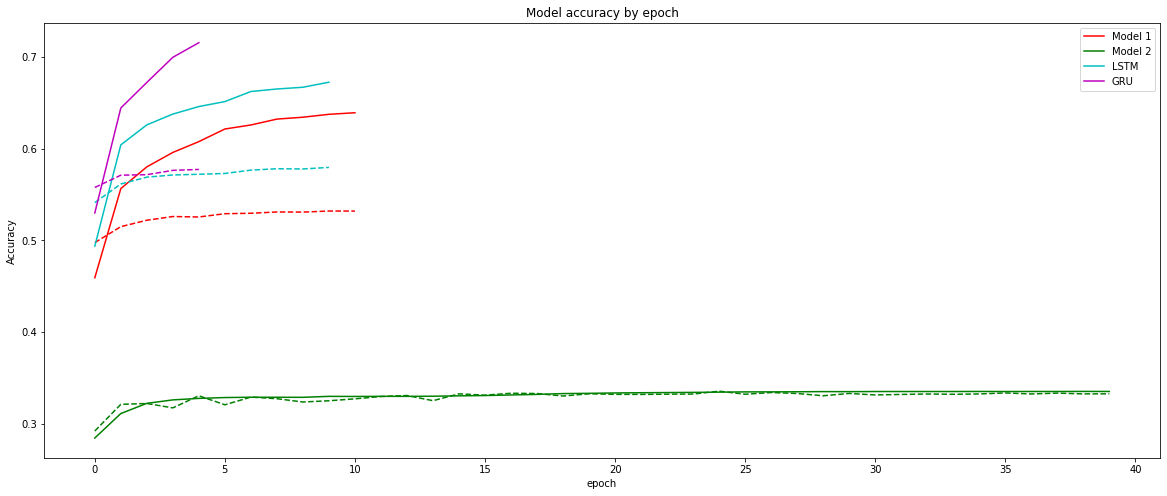

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ax.plot(history1['accuracy'], "-", c = "r", label = "Model 1")
ax.plot(history1['val_accuracy'], "--", c = "r")

ax.plot(history2['accuracy'], "-", c = "g", label = "Model 2")
ax.plot(history2['val_accuracy'], "--", c = "g")

ax.plot(history3['accuracy'], "-", c = "c", label = "LSTM")
ax.plot(history3['val_accuracy'], "--", c = "c")

ax.plot(history4['accuracy'], "-", c = "m", label = "GRU")
ax.plot(history4['val_accuracy'], "--", c = "m")

plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
ax.legend(loc=1)

plt.show()

The GRU and LSTM models are the best, with a validation accuracy of 57%

In [ ]:
def indx_to_str(word_indx, tokenizer, char_level=False):
    if char_level:
        return tokenizer.sequences_to_texts([list(word_indx)])[0].replace(" ", "")
    else:
        return tokenizer.sequences_to_texts([list(word_indx)])[0]
def predict_n_word(model, tokenizer, X_test, n_word=5):
    y_prob = pd.DataFrame(data=model.predict([X_test])[0], columns=["Probability"])
    y_prob = y_prob.sort_values(by="Probability", axis=0, ascending=False).head(n_word)
    y_prob["Word"] = [""]*n_word
    temp = []
    for i in y_prob.index:
        temp.append((indx_to_str([i], tokenizer, char_level=False)))
        
    y_prob["Word"] = temp
    return y_prob

In [ ]:
model_a_tester = model4
i = random.randint(0, len(context_test))
context = indx_to_str(context_test[i], tokenizer, char_level=False)
print("Les mots précédents sont :", context)
start = indx_to_str(start_word_test[i], tokenizer_char, char_level=True)
print("Les lettres déjà tapé sont :", start)
pred = indx_to_str(prediction_test[i], tokenizer, char_level=False)
print("Le mot à prédire est :", pred)


X_test_i = (context_test[i].reshape(1,-1),start_word_test[i].reshape(1,-1))

pred_n_word = predict_n_word(model_a_tester, tokenizer, X_test_i, n_word=5)
if (pred_n_word["Word"]==pred).sum():
    print('Le mot a été trouvé')
else:
    print("Le mot n'a pas été trouvé")
print("\nLes 5 mots principaux prédit par le modele sont:")
pred_n_word

Les mots précédents sont : would provide you with more detailed information as it became
Les lettres déjà tapé sont : availa
Le mot à prédire est : available
Le mot a été trouvé

Les 5 mots principaux prédit par le modele sont:


,Probability,Word
163,9.994416e-01,available
0,4.193040e-04,
1414,1.354152e-04,availability
4184,1.680116e-06,affiliated
5274,3.511928e-07,evaluating


# 2. Modelisation avec mécanisme d'attention

## I. Chargement des données et preprocessing

### Fonctions

In [ ]:
# Conversion du document d'unicode vers ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Prétraitement des phrases
def clean_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([:,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[?.!¿]+ +", "\t", w)
    w = re.sub(r'["\t"]+', "\t", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+.^\t", " ", w)
    w = re.sub(r"[-]{2,}", " ", w)
    w = w.strip() 
    return w

# Extraction des données du fichier source
def preprocess_file(path, num_examples):
    # lecture du ficher
    df = pd.read_csv(path)
    df = df.fillna(' ')
    df['content'] = [x.split('Subject:')[-1] for x in df['content']]
    df = pd.DataFrame(df['content']).head(num_examples)

    sentences = []
    # lecture ligne par ligne
    for l in df['content']:
        # nettoyage de la phase
        sentences2split = clean_sentence(l)
        for s in sentences2split.split('\t'):
            s = decontracted(s)
            for i in range(len(s)):
                splitat = i
                left, right = ' '.join(s[:splitat].split()[-6:]), ' '.join(s[splitat:].split()[:2])
                sentences.append(['<start> ' + left + ' <end>', '<start> ' + right + ' <end>'])
        # reshaping de la liste obtenue
    sentences = pd.DataFrame(sentences).rename({0:'entry', 1:'prediction'},axis=1)
    return sentences

def tokenize(sentences):
    # tokenization des phrases
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    # transformation des phrases en séquences
    seq = tokenizer.texts_to_sequences(sentences)
    # complète les séquences de sorte à ce qu'ils aient la même longueur
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post')
    # post : le padding est réalisé à la fin des séquences
    return seq, tokenizer

def decontracted(w):
    # specific
    w = re.sub(r"won't", "will not", w)
    w = re.sub(r"can\'t", "can not", w)

    # general
    w = re.sub(r"n\'t", " not", w)
    w = re.sub(r"\'re", " are", w)
    w = re.sub(r"\'s", " is", w)
    w = re.sub(r"\'d", " would", w)
    w = re.sub(r"\'ll", " will", w)
    w = re.sub(r"\'t", " not", w)
    w = re.sub(r"\'ve", " have", w)
    w = re.sub(r"\'m", " am", w)
    return w
"""  
def preprocess_txt(data):
    preprocessed = []
    for sentance in data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('^\d+\s|\s\d+\s|\s\d+$', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = re.sub('http[s]?://\S+', '', sent)
        preprocessed.append(sent.lower().strip())
    return preprocessed
"""

'  \ndef preprocess_txt(data):\n    preprocessed = []\n    for sentance in data:\n        sent = decontracted(sentance)\n        sent = sent.replace(\'\\r\', \' \')\n        sent = sent.replace(\'\\"\', \' \')\n        sent = sent.replace(\'\\n\', \' \')\n        sent = sent.replace(\'^\\d+\\s|\\s\\d+\\s|\\s\\d+$\', \' \')\n        sent = re.sub(\'[^A-Za-z0-9]+\', \' \', sent)\n        sent = re.sub(\'http[s]?://\\S+\', \'\', sent)\n        preprocessed.append(sent.lower().strip())\n    return preprocessed\n'

### Pre-processing

In [ ]:
# Chargement des données
n = 100
df = preprocess_file(path+'df_emails.csv', n)
print('Shape de df :', df.shape)

# Tokenization
input_seq, input_tokenizer = tokenize(df['entry'])
target_seq, target_tokenizer = tokenize(df['prediction'])

# Calcul de la taille des vocabulaires
vocab_size_inp = len(input_tokenizer.word_index)+1
vocab_size_targ = len(target_tokenizer.word_index)+1

# Calcul de longeur maximale des séquences 
max_length_inp, max_length_targ = input_seq.shape[1], target_seq.shape[1] 

# Création des ensembles d'apprentissage et test
X_train, X_test, y_train, y_test = train_test_split(input_seq, target_seq,test_size=0.2)

# Paramètres de l'entrainement
buffer_size = len(X_train)
batch_size = 64
steps_per_epoch = len(X_train)//batch_size

# Création du dataset d'entrainement
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

Shape de df : (80708, 2)


In [ ]:
df.iloc[10:20,:]

,entry,prediction
10,<start> here is ou <end>,<start> r forecast <end>
11,<start> here is our <end>,<start> forecast <end>
12,<start> here is our <end>,<start> forecast <end>
13,<start> here is our f <end>,<start> orecast <end>
14,<start> here is our fo <end>,<start> recast <end>
15,<start> here is our for <end>,<start> ecast <end>
16,<start> here is our fore <end>,<start> cast <end>
17,<start> here is our forec <end>,<start> ast <end>
18,<start> here is our foreca <end>,<start> st <end>
19,<start> here is our forecas <end>,<start> t <end>


In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
print("Dimensions du batch input : ", example_input_batch.shape)
print("Dimensions du batch target : ", example_target_batch.shape)

Dimensions du batch input :  (64, 8)
Dimensions du batch target :  (64, 4)


## II. Définition des classes

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.units = latent_dim
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# Paramètres du modèle
latent_dim = 512 
embedding_dim = 300 

encoder = Encoder(vocab_size_inp, embedding_dim, latent_dim)

hidden = encoder.initialize_hidden_state(batch_size)
enc_output, hidden = encoder(example_input_batch, hidden)

print('Dimensions de la sortie de l\'Encodeur : ')
print(' (batch size, max_length_inp, latent_dim) -> {}'.format(enc_output.shape))
print()

print('Dimensions de l\'état caché :')
print(' (batch size, latent_dim) -> {}'.format(hidden.shape))

Dimensions de la sortie de l'Encodeur : 
 (batch size, max_length_inp, latent_dim) -> (64, 8, 512)

Dimensions de l'état caché :
 (batch size, latent_dim) -> (64, 512)


### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, latent_dim, attention_layer):
        super(Decoder, self).__init__()
        
        self.units = latent_dim
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = attention_layer(latent_dim)

    def call(self, x, hidden, enc_output):
        # dimensions de 'enc_output' : (batch_size, max_length_inp, latent_dim)
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # dimensions de 'context_vector' : (batch size, latent_dim)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)

        x = self.embedding(x)
        # dimensions de 'x' : (batch_size, 1, embedding_dim)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # dimensions de 'x' : (batch_size, 1, embedding_dim + latent_dim)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        # dimensions de 'output' : (batch_size * 1, latent_dim )

        output = self.fc(output)
        # dimensions de 'output' : (batch_size, vocab)

        return output, state, attention_weights

### Attention Bahdanau

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, hidden, enc_output):
        # dimensions de 'hidden' : (batch_size, units)
        # dimensions de 'enc_output' : (batch_size, max_length_input, units)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # dimensions de 'hidden_with_time_axis' : (batch_size, 1, units)
        # ce changement de dimension est nécessaire pour le calcul du score

        score = self.V(tf.nn.tanh(
            self.W1(hidden_with_time_axis) + self.W2(enc_output)))
        # dimensions de 'score' : (batch_size, max_length_inp, 1)
        # dimensions avant d'appliquer 'self.V' : (batch_size, max_length_inp, units)

        attention_weights = tf.nn.softmax(score, axis=1)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)

        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # dimensions de context_vector après somme (batch_size, units)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(latent_dim)
attention_result, attention_weights = attention_layer(hidden, enc_output)

print("Dimensions de la sortie de la couche d'attention :")
print(" (batch size, latent_dim) {}".format(attention_result.shape))
print("Dimensions des poids d'attention :")
print(" (batch_size, max_length_inp, 1) {}".format(attention_weights.shape))

Dimensions de la sortie de la couche d'attention :
 (batch size, latent_dim) (64, 512)
Dimensions des poids d'attention :
 (batch_size, max_length_inp, 1) (64, 8, 1)


In [ ]:
decoder = Decoder(vocab_size_targ, embedding_dim, latent_dim, BahdanauAttention)
# decoder = Decoder(vocab_size_targ, embedding_dim, latent_dim, LuongAttention)

dec_input = tf.random.uniform((batch_size, 1))
dec_output, _, _ = decoder(dec_input, hidden, enc_output)

print ('Dimension de la sortie du Décodeur :')
print(' (batch_size, vocab size) -> {}'.format(dec_output.shape))

Dimension de la sortie du Décodeur :
 (batch_size, vocab size) -> (64, 8623)


#### Fonction de perte

In [ ]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam()

#### Entraînement du modèle

In [ ]:
@tf.function
def train_step(inp, targ, enc_initial_hidden):
    
    loss = 0 # initisalisation de la perte

    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_initial_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * batch_size, 1)

        # parcours de chaque élement de 'targ'
        for t in range(1, targ.shape[1]):
            
            # appel au Décodeur
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # calcul de la perte
            loss += loss_function(targ[:, t], predictions)

            # mise à jour de la variable 'dec_input'
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        
        # calcul des variables du modèle
        variables = encoder.trainable_variables + decoder.trainable_variables
    #calcul du gradient du modèle
    gradients = tape.gradient(loss, variables)
    # optimisation des variables du modèle
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
# Checkpoint 
checkpoint_dir = path+'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
def train(n_epoch = 10):

    t=time.time()
    return_loss = []

    for epoch in range(n_epoch):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(batch_size)
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
        return_loss.append(total_loss / steps_per_epoch)

        # conservation du modèle tout les 2 epochs
        #if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


    print("Time elapsed :{}s".format(round(time.time() - t,2)))

    return return_loss

loss = train(n_epoch = 10)

Epoch 1 Batch 0 Loss 6.7256
Epoch 1 Batch 100 Loss 3.4587
Epoch 1 Batch 200 Loss 3.4485
Epoch 1 Batch 300 Loss 3.5417
Epoch 1 Batch 400 Loss 3.1668
Epoch 1 Batch 500 Loss 3.3740
Epoch 1 Batch 600 Loss 3.3252
Epoch 1 Batch 700 Loss 3.3388
Epoch 1 Batch 800 Loss 3.1871
Epoch 1 Batch 900 Loss 3.1646
Epoch 1 Batch 1000 Loss 3.2402
Epoch 1 Loss 3.3961
Time taken for 1 epoch 21.03 sec

Epoch 2 Batch 0 Loss 3.1019
Epoch 2 Batch 100 Loss 2.9353
Epoch 2 Batch 200 Loss 2.9990
Epoch 2 Batch 300 Loss 3.1447
Epoch 2 Batch 400 Loss 2.8923
Epoch 2 Batch 500 Loss 2.9175
Epoch 2 Batch 600 Loss 2.9432
Epoch 2 Batch 700 Loss 2.7263
Epoch 2 Batch 800 Loss 2.6767
Epoch 2 Batch 900 Loss 2.6638
Epoch 2 Batch 1000 Loss 2.4157
Epoch 2 Loss 2.8640
Time taken for 1 epoch 13.29 sec

Epoch 3 Batch 0 Loss 2.4932
Epoch 3 Batch 100 Loss 2.4658
Epoch 3 Batch 200 Loss 2.3609
Epoch 3 Batch 300 Loss 2.3699
Epoch 3 Batch 400 Loss 2.0854
Epoch 3 Batch 500 Loss 2.1570
Epoch 3 Batch 600 Loss 2.0138
Epoch 3 Batch 700 Loss 1.9

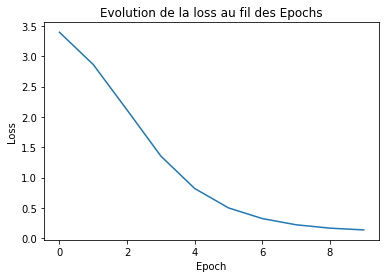

In [ ]:
plt.plot(loss)
plt.title("Evolution de la loss au fil des Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

#### Prédiction

In [ ]:
def predict(sentence, is_seq = False):
    
    # Initialisation de la matrice d'attention
    attention_matrix = np.zeros((max_length_targ, max_length_inp))    
        
    if not(is_seq):
        # prétraitement de la phrase d'entrée
        sentence = clean_sentence(sentence)
        # transformation de la phrase en séquence
        sentence = input_tokenizer.texts_to_sequences([sentence])
        sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,
                                                             maxlen=max_length_input,
                                                             padding='post')
        
    # initialisation des variables
    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(sentence, hidden)
    dec_hidden = enc_hidden
    
    # remplissage du premier élement par l'indice asscoié à la balise <start>
    dec_input = tf.expand_dims([input_tokenizer.word_index['<start>']], 0)

    stop_condition = False # initialisation du status de la traduction
    words = [] # initialisation de la phrase de sortie
    t = 0

    while not stop_condition:
        
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # conservation des poids d'attention
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()

        predicted_index = tf.argmax(predictions[0]).numpy()
        
        if predicted_index != 0:
            word = target_tokenizer.index_word[predicted_index]
        else :
            word = ''

        # the predicted id is fed back into the model
        dec_input = tf.expand_dims([predicted_index], 0)
        
        # verification des conditions de sortie: 
        if (word == '<end>' or # la balise <end> 
           t >= max_length_targ-1): # longeur maximale atteinte
            
            stop_condition = True
            break
            
         # ajout du mot à la phrase de sortie    
        words.append(word)
        
        t+=1

    return " ".join(words), attention_matrix

In [ ]:
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    results = pd.DataFrame()
#    for i in tq(range(20)):
    with tqdm(total=n_test) as pbar:
        for i in range(n_test):
            pbar.update(1)
            x_test = find_sentence(X_test[i], input_tokenizer)
            y_pred, attention_matrix = predict(X_test[i].reshape((-1,max_length_inp)), is_seq = True)
            y_true = find_sentence(y_test[i], target_tokenizer)
            results = results.append({'X_test':x_test, 'y_pred':y_pred, 'y_true':y_true}, ignore_index=True)
        
    return results

results = test(len(X_test))

def clean_results(w):
    w = re.sub(r"<\w*>", " ", w)
    w = w.strip() 
    return w

def score(x,y,z):
    if x.split() and y.split():
        if len(x.split())!=len(y.split()):
            score = 0
        elif z==1 and len(x.split())==1:
            score = 'n/a'
        elif x.split()[z] == y.split()[z]:
            score = 1
        else:
            score = 0
    else:
        score = 0
    return score

results['X_test']=results['X_test'].apply(lambda x: clean_results(x))
results['y_true']=results['y_true'].apply(lambda x: clean_results(x))
results['score_1'] = results.apply(lambda x: score(x['y_pred'], x['y_true'], 0), axis=1)
results['score_2'] = results.apply(lambda x: score(x['y_pred'], x['y_true'], 1), axis=1)
results = results.fillna(' ')
#results['bleu_score'] = results.apply(lambda x: sentence_bleu(x['y_true'].split(), x['y_pred'].split()), axis=1)

print(results.shape)

  0%|          | 0/16142 [00:00<?, ?it/s]

(16142, 5)


In [ ]:
# Ecriture sur le disque
results.to_csv(path+"seq2seq_Bahdanau_results.csv", index=False)

In [ ]:
# Lecture du disque
results = pd.read_csv(path+"seq2seq_Bahdanau_results.csv")
results = results.fillna(' ')

In [ ]:
results.iloc[20:40,:]

,X_test,y_pred,y_true,score_1,score_2
20,payment to cb for any subcontractor,costs that,costs that,1,1.0
21,"lucy , here are the rentrolls",: open,: open,1,1.0
22,and physical trades executed from septe,mber 25,mber 25,1,1.0
23,listed in the cash flow as,part of,part of,1,1.0
24,to hearing from you and to,working with,working with,1,1.0
25,commodity and transport cost (firm o,r >,r >,1,1.0
26,"loans , this generally means that",a larger,a larger,1,1.0
27,the user at gas daily t,o are,oday,0,0.0
28,i need to provide besides headcou,ount,nt,0,
29,", you would clearly receive a",commission on,commission on,1,1.0


1. Taux de bonnes prédictions pour le mot en cours de saisie: (0.72,) % pour 16142 prédictions
2. Taux de bonnes prédictions pour le mot suivant, sachant une bonne prédiction pour le mot en cours: 0.94 % pour 10743 prédictions
3. Taux de bonnes prédictions pour le mot suivant, sachant une mauvaise prédiction pour le mot en cours: 0.4 % pour 4268 prédictions


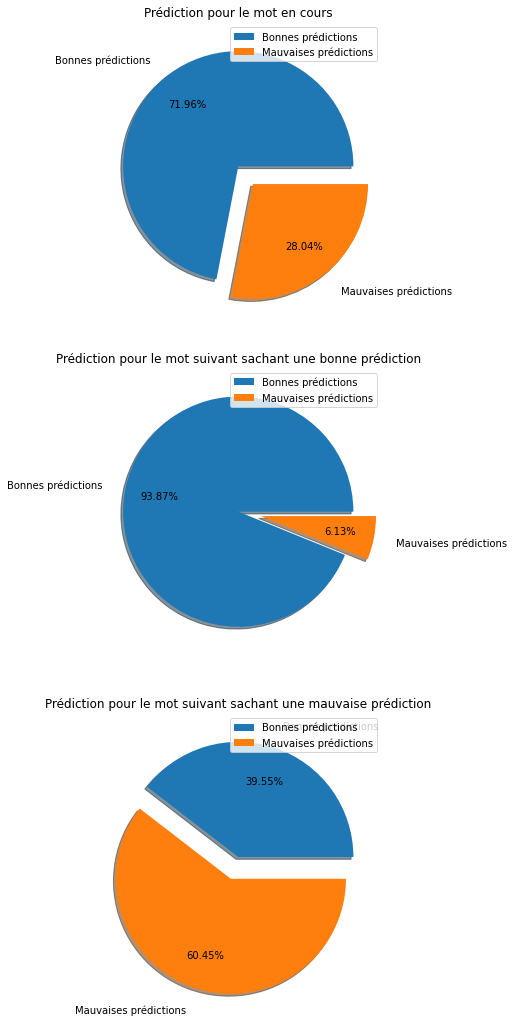

In [ ]:
somme = {}
taille = {}
taux = {}
titre = {}

somme[0] = sum(results['score_1'])
taille[0] = len(results['score_1'])
taux[0] = round(somme[0]/taille[0], 2),
titre[0] = "Prédiction pour le mot en cours"

somme[1] = sum(results[results['score_1']==1]['score_2'][results['score_2']!=' '])
taille[1] = len(results[results['score_1']==1]['score_2'][results['score_2']!=' '])
taux[1] = round(somme[1]/taille[1], 2)
titre[1] = "Prédiction pour le mot suivant sachant une bonne prédiction"

somme[2] = sum(results[results['score_1']==0]['score_2'][results['score_2']!=' '])
taille[2] = len(results[results['score_1']==0]['score_2'][results['score_2']!=' '])
taux[2] = round(somme[2]/taille[2], 2)
titre[2] = "Prédiction pour le mot suivant sachant une mauvaise prédiction"

print("1. Taux de bonnes prédictions pour le mot en cours de saisie:", 
      taux[0],
      "% pour", 
      taille[0],
      "prédictions")

print("2. Taux de bonnes prédictions pour le mot suivant, sachant une bonne prédiction pour le mot en cours:", 
      taux[1],
      "% pour", 
      taille[1],
      "prédictions")

print("3. Taux de bonnes prédictions pour le mot suivant, sachant une mauvaise prédiction pour le mot en cours:", 
      taux[2],
      "% pour", 
      taille[2],
      "prédictions")


plt.figure(figsize= (12,18))
for i in range(3):
    plt.subplot(3,1,i+1)

    goodPred = somme[i]
    badPred = taille[i]-goodPred
    plt.pie([goodPred, badPred],
            labels=['Bonnes prédictions', 'Mauvaises prédictions'], 
            explode=[0,0.2],
            autopct= lambda x: str(round(x, 2)) + '%',
            pctdistance=0.7,
            labeldistance=1.2,
            shadow=True
           )
    plt.title(titre[i])
    plt.legend();

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):   
    
    # reshapping de la matrice pour supprimer les lignes nulles
    for j in range(attention.shape[0]):
        if (np.sum(attention[j])) == 0:
            break
    l = np.arange(j, attention.shape[0])
    attention = np.delete(attention, l, axis=0) # lignes nulles
    #attention = np.delete(attention, l, axis=1) # colonnes nulles

    # affichage de la matrice
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

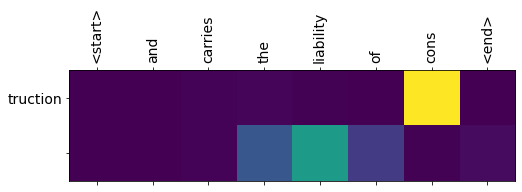

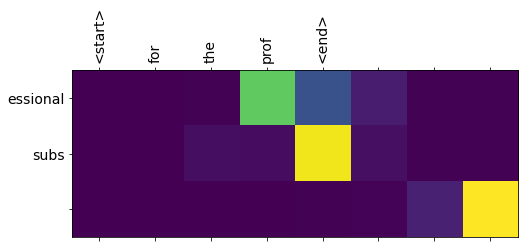

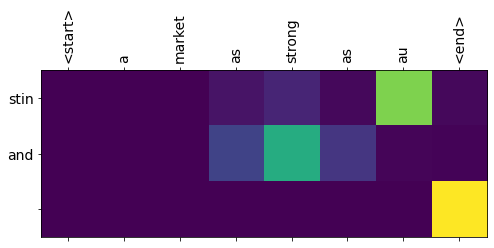

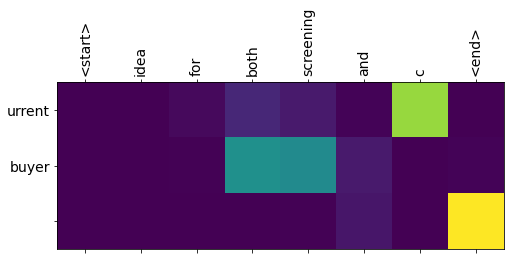

In [ ]:
for k in range(4):
    i = np.random.randint(int(n*0.2))

    x_test = find_sentence(X_train[i], input_tokenizer)
    y_pred, attention_matrix = predict(X_train[i].reshape((-1,max_length_inp)), is_seq = True)
    y_true = find_sentence(y_train[i], target_tokenizer)

    plot_attention(attention_matrix, x_test.split(), y_pred.split())

### Attention Luong

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        
        self.W = tf.keras.layers.Dense(units)
    
    def call(self, hidden, enc_output):
        # dimensions de 'hidden' : (batch_size, units)
        # dimensions de 'enc_output' : (batch_size, max_length_input, units)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # dimensions de 'hidden_with_time_axis' : (batch_size, 1, units)
    
        score = tf.matmul(hidden_with_time_axis, self.W(enc_output), transpose_b=True)
        # dimensions de 'score' : (batch_size, max_length_inp, 1)
        # dimensions avant d'appliquer 'self.V' : (batch_size, max_length_inp, units)
       
        attention_weights = tf.nn.softmax(score, axis=1)
        # dimensions de 'attention_weights' : (batch_size, max_length_inp, 1)
        
        context_vector = tf.matmul(attention_weights, enc_output)
        # dimensions de 'context_vector' après somme (batch_size, units)
        
        context_vector = tf.reshape(context_vector, [-1, latent_dim])
        attention_weights = tf.reshape(attention_weights, [-1, max_length_inp, 1])

        return context_vector, attention_weights

In [ ]:
attention_layer = LuongAttention(latent_dim)
attention_result, attention_weights = attention_layer(hidden, enc_output)

print("Dimensions de la sortie de la couche d'attention :")
print(" (batch size, latent_dim) {}".format(attention_result.shape))
print("Dimensions des poids d'attention :")
print(" (batch_size, max_length_inp, 1) {}".format(attention_weights.shape))

Dimensions de la sortie de la couche d'attention :
 (batch size, latent_dim) (64, 512)
Dimensions des poids d'attention :
 (batch_size, max_length_inp, 1) (64, 8, 1)


In [ ]:
decoder = Decoder(vocab_size_targ, embedding_dim, latent_dim, LuongAttention)

dec_input = tf.random.uniform((batch_size, 1))
dec_output, _, _ = decoder(dec_input, hidden, enc_output)

print ('Dimension de la sortie du Décodeur :')
print(' (batch_size, vocab size) -> {}'.format(dec_output.shape))

Dimension de la sortie du Décodeur :
 (batch_size, vocab size) -> (64, 8623)


#### Fonction de perte

In [ ]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam()

#### Entraînement du modèle

In [ ]:
@tf.function
def train_step(inp, targ, enc_initial_hidden):
    
    loss = 0 # initisalisation de la perte

    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_initial_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * batch_size, 1)

        # parcours de chaque élement de 'targ'
        for t in range(1, targ.shape[1]):
            
            # appel au Décodeur
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # calcul de la perte
            loss += loss_function(targ[:, t], predictions)

            # mise à jour de la variable 'dec_input'
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        
        # calcul des variables du modèle
        variables = encoder.trainable_variables + decoder.trainable_variables
    #calcul du gradient du modèle
    gradients = tape.gradient(loss, variables)
    # optimisation des variables du modèle
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
# Checkpoint 
checkpoint_dir = path+'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
def train(n_epoch = 10):

    t=time.time()
    return_loss = []

    for epoch in range(n_epoch):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(batch_size)
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
        return_loss.append(total_loss / steps_per_epoch)

        # conservation du modèle tout les 2 epochs
        #if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


    print("Time elapsed :{}s".format(round(time.time() - t,2)))

    return return_loss

loss = train(n_epoch = 10)

Epoch 1 Batch 0 Loss 6.5780
Epoch 1 Batch 100 Loss 3.4952
Epoch 1 Batch 200 Loss 3.0060
Epoch 1 Batch 300 Loss 2.8953
Epoch 1 Batch 400 Loss 2.5385
Epoch 1 Batch 500 Loss 2.2575
Epoch 1 Batch 600 Loss 2.2515
Epoch 1 Batch 700 Loss 1.9414
Epoch 1 Batch 800 Loss 1.7416
Epoch 1 Batch 900 Loss 1.7140
Epoch 1 Batch 1000 Loss 1.7957
Epoch 1 Loss 2.4990
Time taken for 1 epoch 18.24 sec

Epoch 2 Batch 0 Loss 1.5193
Epoch 2 Batch 100 Loss 1.1876
Epoch 2 Batch 200 Loss 1.1549
Epoch 2 Batch 300 Loss 1.0464
Epoch 2 Batch 400 Loss 1.0324
Epoch 2 Batch 500 Loss 1.0123
Epoch 2 Batch 600 Loss 1.1263
Epoch 2 Batch 700 Loss 0.9427
Epoch 2 Batch 800 Loss 0.8299
Epoch 2 Batch 900 Loss 1.0465
Epoch 2 Batch 1000 Loss 1.2666
Epoch 2 Loss 1.0939
Time taken for 1 epoch 13.23 sec

Epoch 3 Batch 0 Loss 0.5319
Epoch 3 Batch 100 Loss 0.6242
Epoch 3 Batch 200 Loss 0.5245
Epoch 3 Batch 300 Loss 0.6302
Epoch 3 Batch 400 Loss 0.6292
Epoch 3 Batch 500 Loss 0.6629
Epoch 3 Batch 600 Loss 0.5900
Epoch 3 Batch 700 Loss 0.6

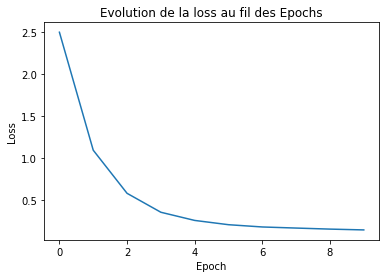

In [ ]:
plt.plot(loss)
plt.title("Evolution de la loss au fil des Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

#### Prédiction

In [ ]:
def predict(sentence, is_seq = False):
    
    # Initialisation de la matrice d'attention
    attention_matrix = np.zeros((max_length_targ, max_length_inp))    
        
    if not(is_seq):
        # prétraitement de la phrase d'entrée
        sentence = clean_sentence(sentence)
        # transformation de la phrase en séquence
        sentence = input_tokenizer.texts_to_sequences([sentence])
        sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,
                                                             maxlen=max_length_input,
                                                             padding='post')
        
    # initialisation des variables
    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(sentence, hidden)
    dec_hidden = enc_hidden
    
    # remplissage du premier élement par l'indice asscoié à la balise <start>
    dec_input = tf.expand_dims([input_tokenizer.word_index['<start>']], 0)

    stop_condition = False # initialisation du status de la traduction
    words = [] # initialisation de la phrase de sortie
    t = 0

    while not stop_condition:
        
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # conservation des poids d'attention
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()

        predicted_index = tf.argmax(predictions[0]).numpy()
        
        if predicted_index != 0:
            word = target_tokenizer.index_word[predicted_index]
        else :
            word = ''

        # the predicted id is fed back into the model
        dec_input = tf.expand_dims([predicted_index], 0)
        
        # verification des conditions de sortie: 
        if (word == '<end>' or # la balise <end> 
           t >= max_length_targ-1): # longeur maximale atteinte
            
            stop_condition = True
            break
            
         # ajout du mot à la phrase de sortie    
        words.append(word)
        
        t+=1

    return " ".join(words), attention_matrix

In [ ]:
def find_sentence(seq, tokenizer):
    sentence = ""
    for s in seq:
        if s!=0: 
            sentence += " " + tokenizer.index_word[s]
    return sentence

def test(n_test):
    
    results = pd.DataFrame()
#    for i in tq(range(20)):
    with tqdm(total=n_test) as pbar:
        for i in range(n_test):
            pbar.update(1)
            x_test = find_sentence(X_test[i], input_tokenizer)
            y_pred, attention_matrix = predict(X_test[i].reshape((-1,max_length_inp)), is_seq = True)
            y_true = find_sentence(y_test[i], target_tokenizer)
            results = results.append({'X_test':x_test, 'y_pred':y_pred, 'y_true':y_true}, ignore_index=True)
        
    return results

results = test(len(X_test))

def clean_results(w):
    w = re.sub(r"<\w*>", " ", w)
    w = w.strip() 
    return w

def score(x,y,z):
    if x.split() and y.split():
        if len(x.split())!=len(y.split()):
            score = 0
        elif z==1 and len(x.split())==1:
            score = 'n/a'
        elif x.split()[z] == y.split()[z]:
            score = 1
        else:
            score = 0
    else:
        score = 0
    return score

results['X_test']=results['X_test'].apply(lambda x: clean_results(x))
results['y_true']=results['y_true'].apply(lambda x: clean_results(x))
results['score_1'] = results.apply(lambda x: score(x['y_pred'], x['y_true'], 0), axis=1)
results['score_2'] = results.apply(lambda x: score(x['y_pred'], x['y_true'], 1), axis=1)
results = results.fillna(' ')

print(results.shape)

  0%|          | 0/16142 [00:00<?, ?it/s]

(16142, 5)


In [ ]:
# Ecriture sur le disque
results.to_csv(path+"seq2seq_Luong_results.csv", index=False)

In [ ]:
results = pd.read_csv(path+"seq2seq_Luong_results.csv")
results = results.fillna(' ')

In [ ]:
results.iloc[20:40,:]

,X_test,y_pred,y_true,score_1,score_2
20,payment to cb for any subcontractor,costs that,costs that,1,1.0
21,"lucy , here are the rentrolls",: open,: open,1,1.0
22,and physical trades executed from septe,mber 25,mber 25,1,1.0
23,listed in the cash flow as,part of,part of,1,1.0
24,to hearing from you and to,working with,working with,1,1.0
25,commodity and transport cost (firm o,r >,r >,1,1.0
26,"loans , this generally means that",a larger,a larger,1,1.0
27,the user at gas daily t,o cb,oday,0,0.0
28,i need to provide besides headcou,count,nt,0,
29,", you would clearly receive a",commission on,commission on,1,1.0


1. Taux de bonnes prédictions pour le mot en cours de saisie: (0.7,) % pour 16142 prédictions
2. Taux de bonnes prédictions pour le mot suivant, sachant une bonne prédiction pour le mot en cours: 0.94 % pour 10353 prédictions
3. Taux de bonnes prédictions pour le mot suivant, sachant une mauvaise prédiction pour le mot en cours: 0.37 % pour 4639 prédictions


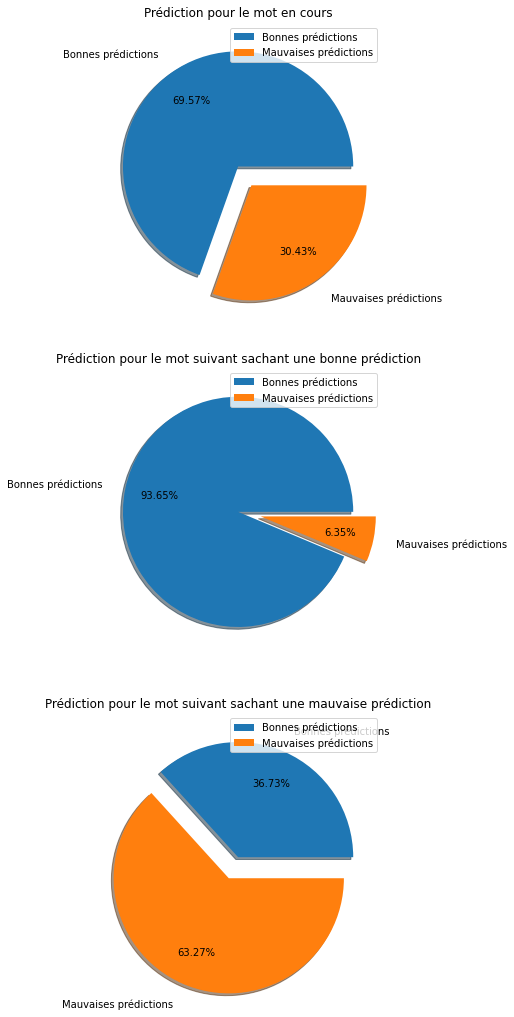

In [ ]:
somme = {}
taille = {}
taux = {}
titre = {}

somme[0] = sum(results['score_1'])
taille[0] = len(results['score_1'])
taux[0] = round(somme[0]/taille[0], 2),
titre[0] = "Prédiction pour le mot en cours"

somme[1] = sum(results[results['score_1']==1]['score_2'][results['score_2']!=' '])
taille[1] = len(results[results['score_1']==1]['score_2'][results['score_2']!=' '])
taux[1] = round(somme[1]/taille[1], 2)
titre[1] = "Prédiction pour le mot suivant sachant une bonne prédiction"

somme[2] = sum(results[results['score_1']==0]['score_2'][results['score_2']!=' '])
taille[2] = len(results[results['score_1']==0]['score_2'][results['score_2']!=' '])
taux[2] = round(somme[2]/taille[2], 2)
titre[2] = "Prédiction pour le mot suivant sachant une mauvaise prédiction"

print("1. Taux de bonnes prédictions pour le mot en cours de saisie:", 
      taux[0],
      "% pour", 
      taille[0],
      "prédictions")

print("2. Taux de bonnes prédictions pour le mot suivant, sachant une bonne prédiction pour le mot en cours:", 
      taux[1],
      "% pour", 
      taille[1],
      "prédictions")

print("3. Taux de bonnes prédictions pour le mot suivant, sachant une mauvaise prédiction pour le mot en cours:", 
      taux[2],
      "% pour", 
      taille[2],
      "prédictions")


plt.figure(figsize= (12,18))
for i in range(3):
    plt.subplot(3,1,i+1)

    goodPred = somme[i]
    badPred = taille[i]-goodPred
    plt.pie([goodPred, badPred],
            labels=['Bonnes prédictions', 'Mauvaises prédictions'], 
            explode=[0,0.2],
            autopct= lambda x: str(round(x, 2)) + '%',
            pctdistance=0.7,
            labeldistance=1.2,
            shadow=True
           )
    plt.title(titre[i])
    plt.legend();

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):   
    
    # reshapping de la matrice pour supprimer les lignes nulles
    for j in range(attention.shape[0]):
        if (np.sum(attention[j])) == 0:
            break
    l = np.arange(j, attention.shape[0])
    attention = np.delete(attention, l, axis=0) # lignes nulles
    #attention = np.delete(attention, l, axis=1) # colonnes nulles

    # affichage de la matrice
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

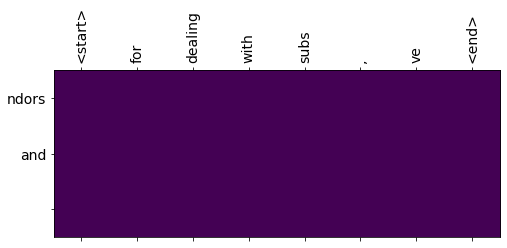

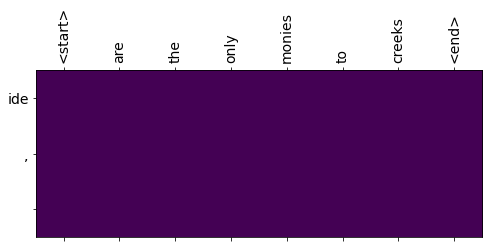

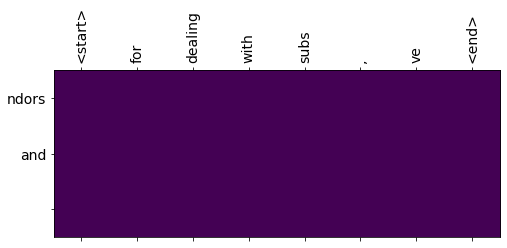

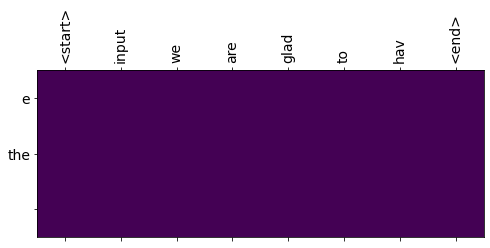

In [ ]:
for k in range(4):
    i = np.random.randint(int(n*0.2))

    x_test = find_sentence(X_train[i], input_tokenizer)
    y_pred, attention_matrix = predict(X_train[i].reshape((-1,max_length_inp)), is_seq = True)
    y_true = find_sentence(y_train[i], target_tokenizer)

    plot_attention(attention_matrix, x_test.split(), y_pred.split())